# Branin Currin MOO Test


**TODO**:

- See if we are still getting `None` gradients in the VSD optimization loop
- Try the a generative BORE acquisition, see `vsd.acquisition.PreferenceAcquisition`

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as fnn
from botorch.test_functions.multi_objective import BraninCurrin
from scipy.stats.qmc import LatinHypercube

from vsd.preferences import (
    UnitNormal,
    MixtureUnitNormal,
    EmpiricalPreferences,
)
from vsd.condproposals import (
    ConditionalGaussianProposal,
    PreferenceSearchDistribution
)
from vsd.proposals import fit_ml
from vsd.cpe import (
    PreferenceContinuousCPE,
    fit_cpe_labels,
    make_constrastive_alignment_data
)
from vsd.acquisition import VariationalPreferenceAcquisition
from vsd.generation import generate_candidates_iw
from vsd.utils import is_non_dominated_strict

/Users/ste702/Code/agps/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup the problem

In [2]:
# Patch BraninCurrin function to transform inputs into [0, 1]^2
Y_SCALE = torch.tensor([200., 4.])
class BraninCurrinTfm(BraninCurrin):

    def __call__(self, X):
        y = super().__call__(torch.sigmoid(X)) / Y_SCALE
        return y

In [ ]:
SEED = 42
torch.manual_seed(SEED)

# Black box
bb = BraninCurrinTfm(negate=False)

# Initial points in [0, 1]^2
N_INIT, D, L = 50, 2, 2
# X = torch.randn(size=[N_INIT, D])
X = torch.tensor(LatinHypercube(d=D).random(n=N_INIT) * 4 - 2).float()
y = bb(X)

# Intial pareto labels
z = is_non_dominated_strict(y)

# Optimization settings
USE_EMPIRICAL_PREFERENCES = False
ROUNDS = 10
BATCHSIZE = 96

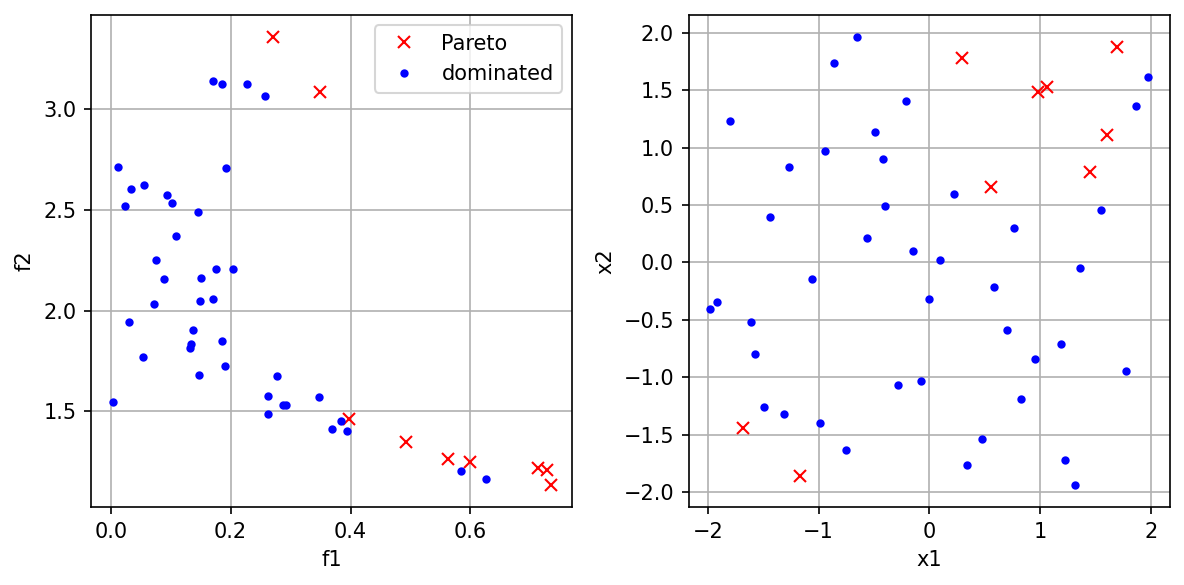

In [4]:
# Plot intitial data
f, axs = plt.subplots(1, 2, dpi=150, figsize=(8, 4))
axs[0].plot(y[z==1, 0], y[z==1, 1], 'rx', label="Pareto")
axs[0].plot(y[z==0, 0], y[z==0, 1], 'b.', label="dominated")
axs[0].set_xlabel("f1")
axs[0].set_ylabel("f2")
axs[0].legend()
axs[0].grid()
axs[1].plot(X[z==1, 0], X[z==1, 1], 'rx', label="Pareto")
axs[1].plot(X[z==0, 0], X[z==0, 1], 'b.', label="dominated")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
axs[1].grid()
plt.tight_layout()
plt.show()

## Setup VSD-MOO components


### Preferences

In [5]:
# Preference distribution, q(λ)
if USE_EMPIRICAL_PREFERENCES:
    preferences = EmpiricalPreferences()
else:
    preferences = UnitNormal(dim=L)
    mu = fnn.normalize(torch.rand((5, 2)), p=2, dim=-1)
    preferences = MixtureUnitNormal(locs=mu)

# Fitting routine
def callback_pref(i, loss, _):
    if (i % 100) == 0:
        print(f"  {i}: loss = {loss:.3f}")

def fit_preferences(q, U, z, round):
    fit_ml(
        q,
        U[z==1, :] if round > 0 else U,
        stop_options=dict(n_window=1000, maxiter=5000),
        optimizer_options=dict(lr=1e-3, weight_decay=1e-8),
        callback=callback_pref
    )

### CPEs

In [6]:
# CPE models -- NNs
pareto_cpe = PreferenceContinuousCPE(
    x_dim=D,
    u_dims=L,
    latent_dim=16,
    dropoutp=0.1
)

preference_cpe = PreferenceContinuousCPE(
    x_dim=D,
    u_dims=L,
    latent_dim=16,
    dropoutp=0.1
)

# Fitting routines
def fit_pareto_cpe(cpe, X, U, z):
    fit_cpe_labels(
        model=cpe, X=X, U=U, z=z.type(dtype=torch.float32),
        callback=callback_pref,
        batch_size=32,
        optimizer_options=dict(lr=1e-3, weight_decay=1e-2),
        stop_options=dict(n_window=1000)
    )

def fit_preference_cpe(cpe, X, U):
    # Augment dataset with misalignments
    Xa, Ua, za = make_constrastive_alignment_data(X, U)

    fit_cpe_labels(
        model=cpe, X=Xa, U=Ua, z=za,
        callback=callback_pref,
        batch_size=32,
        optimizer_options=dict(lr=1e-3, weight_decay=1e-2),
        stop_options=dict(n_window=1000)
    )

### MOO VSD

In [7]:
# Prior, p(x)
prior = torch.distributions.MultivariateNormal(
    loc=torch.zeros((1, D)),
    precision_matrix=torch.eye(D) * .01  # Precision matrix
)

# Variational distribution, q(x|u)
cproposal = ConditionalGaussianProposal(
    x_dims=D,
    u_dims=L,
    latent_dim=8,
    bias=True
)
# cproposal = CondGaussianKDEProposal(
#     x_dims=D,
#     u_dims=M,
#     latent_dim=8,
#     k_components=3,
#     bias=True,
# )

# Joint posterior, q(x, u)
proposal = PreferenceSearchDistribution(
    cproposal=cproposal,
    preference=preferences
)

# Acquisition function -- ELBO
acq = VariationalPreferenceAcquisition(
    pareto_model=pareto_cpe,
    pref_model=preference_cpe,
    prior_dist=prior
)


# Fitting routine
def vsd_callback(i, loss, grads):
    if (i % 100) == 0:
        # gmean = torch.mean([g.detach().mean() for g in grads])
        gmean = sum([g.detach().mean() for g in grads if g is not None]) / len(grads)
        print(f"  {i}: loss = {-loss:.3f}, mean grad = {gmean:.3f}")

def fit_vsd(acq, proposal):
    # generate_candidates_reinforce(
    generate_candidates_iw(
        acq,
        proposal,
        optimizer_options=dict(lr=1e-3),
        stop_options=dict(n_window=3000),
        gradient_samples=512,
        callback=vsd_callback,
    )

## BB optimization loop

ROUND: 1
Learning preferences ...
  0: loss = 2.115
  100: loss = 1.924
  200: loss = 1.739
  300: loss = 1.555
  400: loss = 1.372
  500: loss = 1.189
  600: loss = 1.002
  700: loss = 0.810
  800: loss = 0.612
  900: loss = 0.405
  1000: loss = 0.187
  1100: loss = -0.043
  1200: loss = -0.280
  1300: loss = -0.520
  1400: loss = -0.773
  1500: loss = -1.050
  1600: loss = -1.339
  1700: loss = -1.610
  1800: loss = -1.841
  1900: loss = -2.031
  2000: loss = -2.191
  2100: loss = -2.329
  2200: loss = -2.455
  2300: loss = -2.572
  2400: loss = -2.682
  2500: loss = -2.787
  2600: loss = -2.888
  2700: loss = -2.985
  2800: loss = -3.076
  2900: loss = -3.163
  3000: loss = -3.244
  3100: loss = -3.320
  3200: loss = -3.390
  3300: loss = -3.455
  3400: loss = -3.518
  3500: loss = -3.587
  3600: loss = -3.660
  3700: loss = -3.726
  3800: loss = -3.785
  3900: loss = -3.838
  4000: loss = -3.886
  4100: loss = -3.928
  4200: loss = -3.965
  4300: loss = -3.998
  4400: loss = -4.028

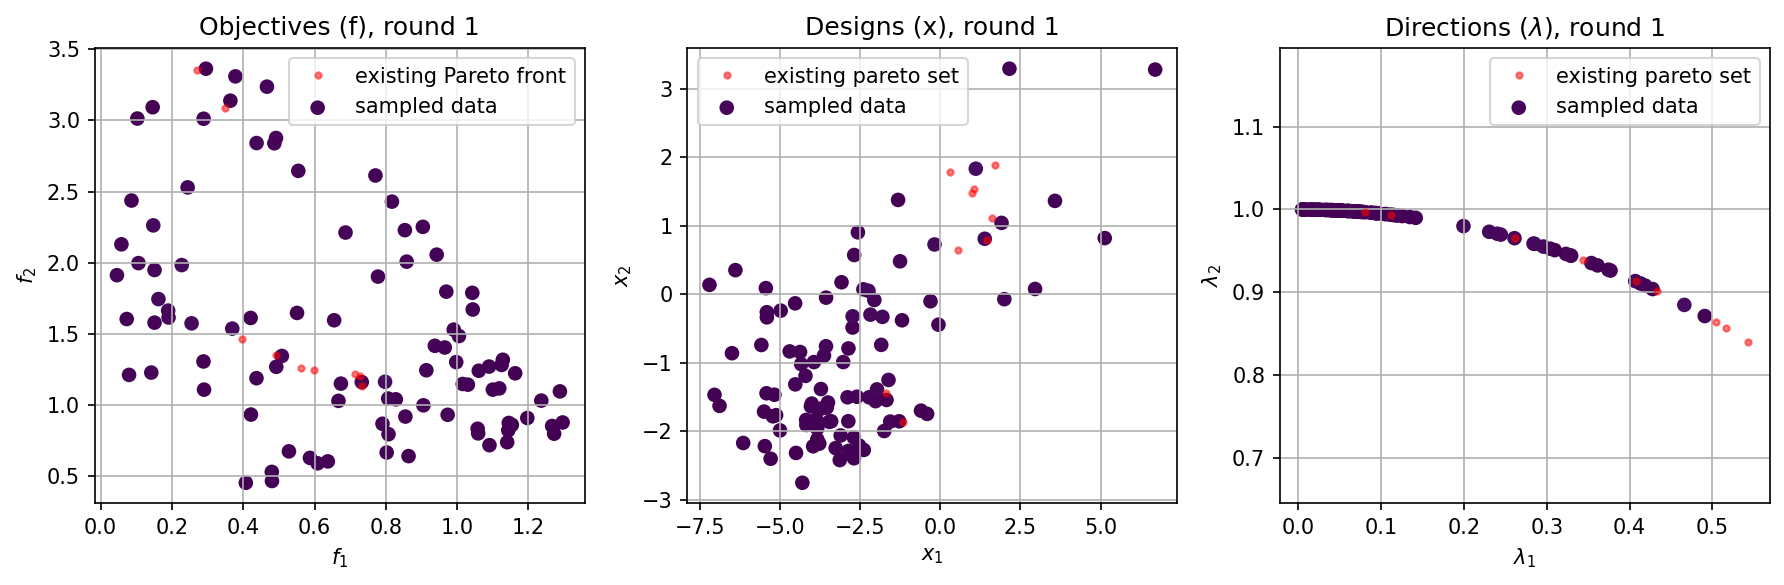


ROUND: 2
Learning preferences ...
  0: loss = -0.272
  100: loss = -1.301
  200: loss = -1.474
  300: loss = -1.583
  400: loss = -1.666
  500: loss = -1.730
  600: loss = -1.779
  700: loss = -1.822
  800: loss = -1.864
  900: loss = -1.909
  1000: loss = -1.957
  1100: loss = -2.016
  1200: loss = -2.108
  1300: loss = -2.211
  1400: loss = -2.307
  1500: loss = -2.392
  1600: loss = -2.466
  1700: loss = -2.530
  1800: loss = -2.588
  1900: loss = -2.639
  2000: loss = -2.682
  2100: loss = -2.716
  2200: loss = -2.741
  2300: loss = -2.760
  2400: loss = -2.777
  2500: loss = -2.800
  2600: loss = -2.829
  2700: loss = -2.862
  2800: loss = -2.895
  2900: loss = -2.926
  3000: loss = -2.956
  3100: loss = -2.984
  3200: loss = -3.010
  3300: loss = -3.036
  3400: loss = -3.060
  3500: loss = -3.084
  3600: loss = -3.106
  3700: loss = -3.128
  3800: loss = -3.149
  3900: loss = -3.169
  4000: loss = -3.188
  4100: loss = -3.207
  4200: loss = -3.225
  4300: loss = -3.242
  4400: l

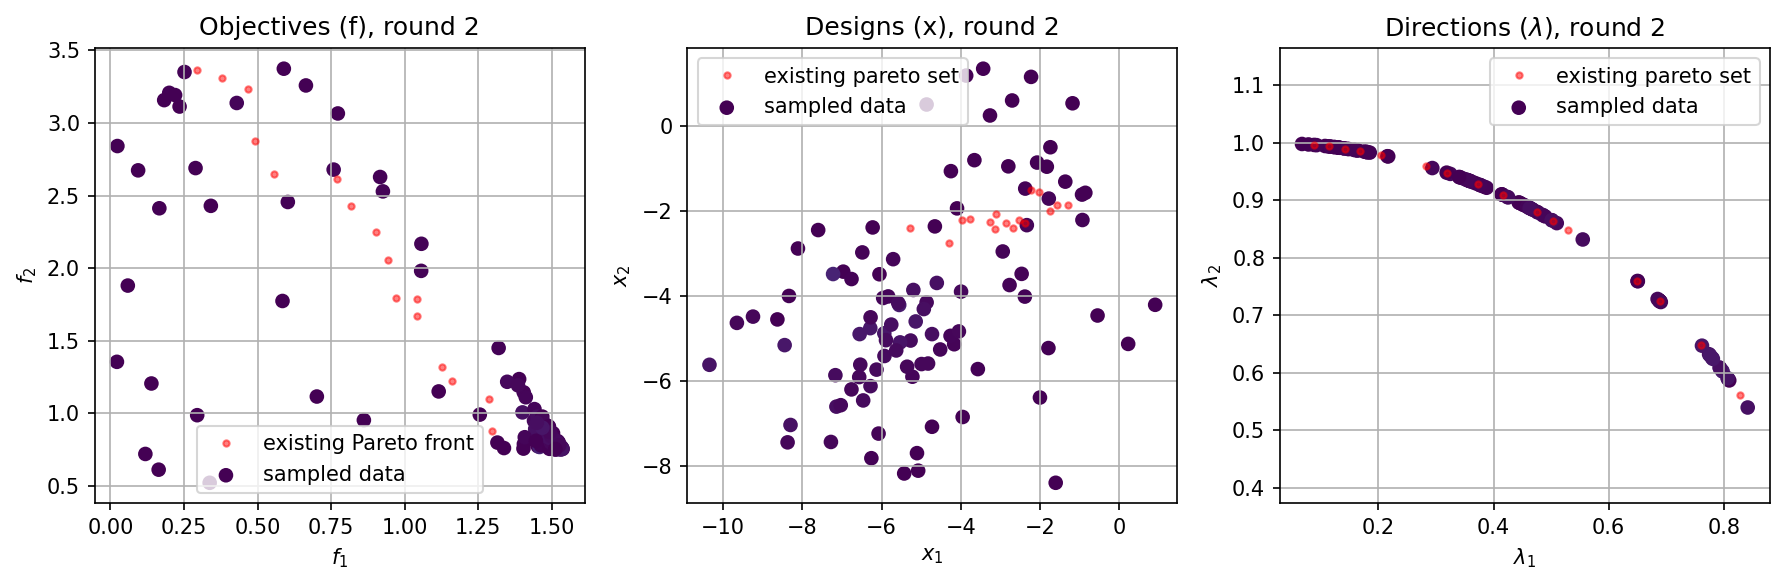


ROUND: 3
Learning preferences ...
  0: loss = 2.237
  100: loss = -1.062
  200: loss = -1.314
  300: loss = -1.483
  400: loss = -1.626
  500: loss = -1.747
  600: loss = -1.848
  700: loss = -1.933
  800: loss = -2.004
  900: loss = -2.065
  1000: loss = -2.122
  1100: loss = -2.170
  1200: loss = -2.210
  1300: loss = -2.243
  1400: loss = -2.276
  1500: loss = -2.311
  1600: loss = -2.345
  1700: loss = -2.376
  1800: loss = -2.401
  1900: loss = -2.419
  2000: loss = -2.433
  2100: loss = -2.445
  2200: loss = -2.454
  2300: loss = -2.462
  2400: loss = -2.469
  2500: loss = -2.475
  2600: loss = -2.480
  2700: loss = -2.484
  2800: loss = -2.487
  2900: loss = -2.489
  3000: loss = -2.491
  3100: loss = -2.492
  3200: loss = -2.493
  3300: loss = -2.494
Learning Pareto CPE ...
  0: loss = 0.143
  100: loss = 0.129
  200: loss = 0.161
  300: loss = 0.249
  400: loss = 0.143
  500: loss = 0.101
  600: loss = 0.111
  700: loss = 0.134
  800: loss = 0.168
  900: loss = 0.184
  1000: 

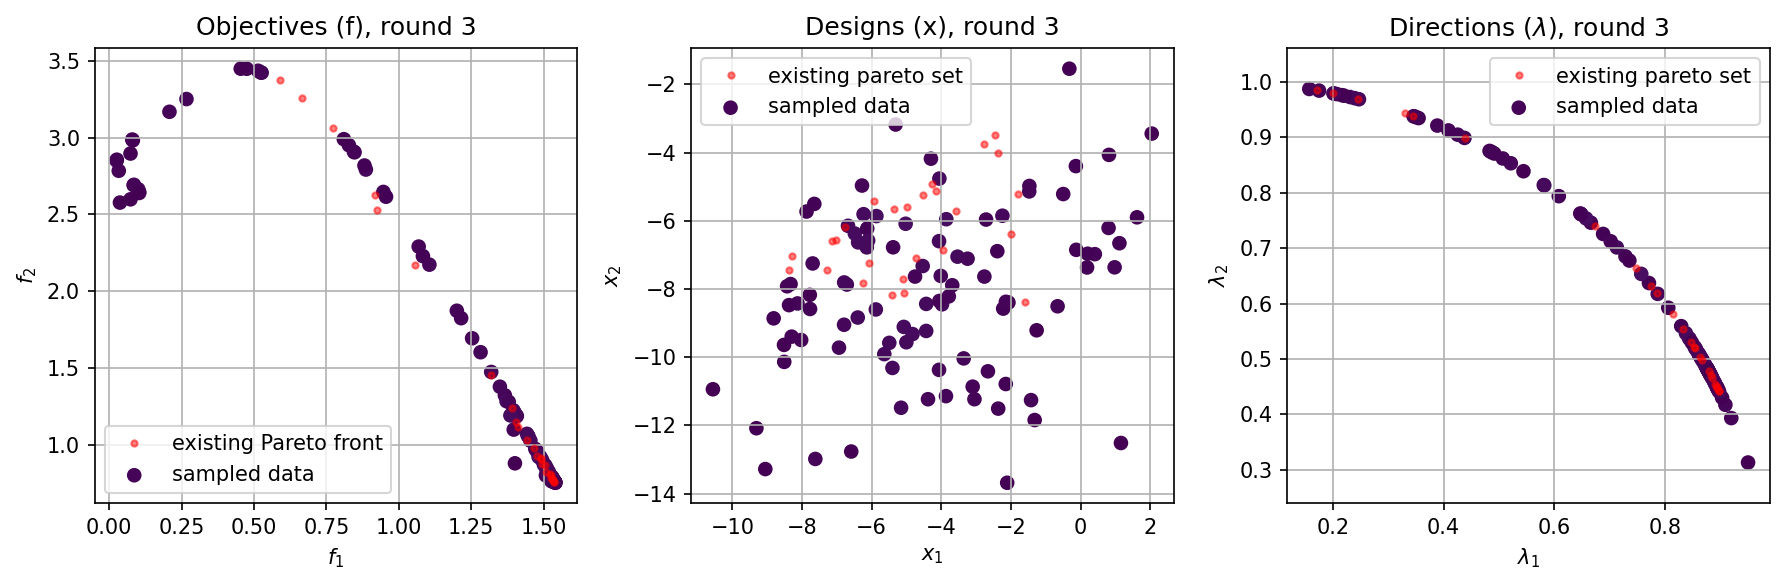


ROUND: 4
Learning preferences ...
  0: loss = -1.843
  100: loss = -2.049
  200: loss = -2.065
  300: loss = -2.076
  400: loss = -2.084
  500: loss = -2.090
  600: loss = -2.095
  700: loss = -2.098
  800: loss = -2.101
  900: loss = -2.103
  1000: loss = -2.105
  1100: loss = -2.106
  1200: loss = -2.108
  1300: loss = -2.109
  1400: loss = -2.110
Learning Pareto CPE ...
  0: loss = 0.141
  100: loss = 0.362
  200: loss = 0.297
  300: loss = 0.141
  400: loss = 0.162
  500: loss = 0.473
  600: loss = 0.188
  700: loss = 0.362
  800: loss = 0.180
  900: loss = 0.095
  1000: loss = 0.246
Learning preference CPE ...
  0: loss = 0.135
  100: loss = 0.185
  200: loss = 0.037
  300: loss = 0.364
  400: loss = 0.218
  500: loss = 0.207
  600: loss = 0.275
  700: loss = 0.035
  800: loss = 0.037
  900: loss = 0.216
  1000: loss = 0.128
Learning Pareto set model ...
  0: loss = -7.575, mean grad = 0.058
  100: loss = -6.806, mean grad = -0.003
  200: loss = -6.730, mean grad = -0.001
  300: 

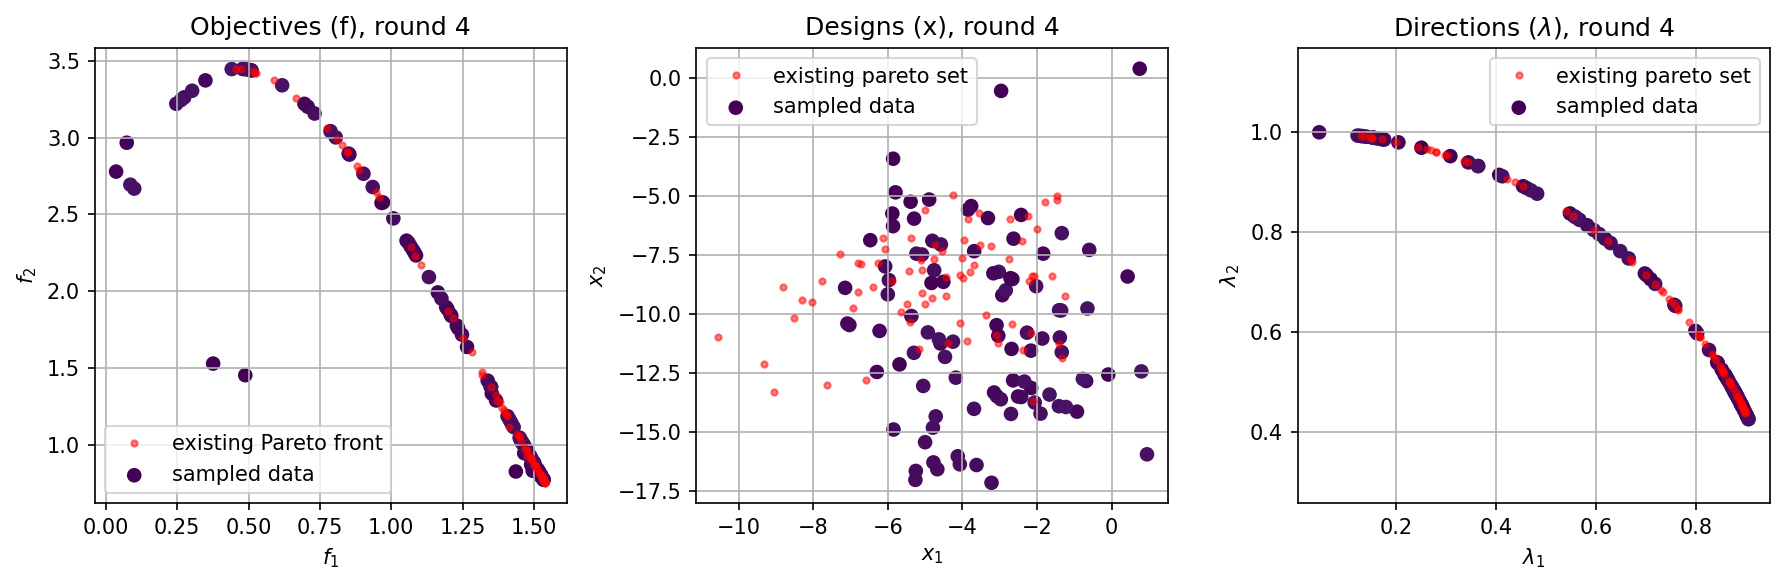


ROUND: 5
Learning preferences ...
  0: loss = -1.815
  100: loss = -1.938
  200: loss = -1.973
  300: loss = -1.991
  400: loss = -2.001
  500: loss = -2.006
  600: loss = -2.009
  700: loss = -2.011
  800: loss = -2.013
  900: loss = -2.015
  1000: loss = -2.017
  1100: loss = -2.020
  1200: loss = -2.023
  1300: loss = -2.025
  1400: loss = -2.027
  1500: loss = -2.032
  1600: loss = -2.037
  1700: loss = -2.040
  1800: loss = -2.042
  1900: loss = -2.044
  2000: loss = -2.046
  2100: loss = -2.047
  2200: loss = -2.048
  2300: loss = -2.049
Learning Pareto CPE ...
  0: loss = 0.166
  100: loss = 0.404
  200: loss = 0.216
  300: loss = 0.279
  400: loss = 0.295
  500: loss = 0.237
  600: loss = 0.220
  700: loss = 0.278
  800: loss = 0.230
  900: loss = 0.259
  1000: loss = 0.216
Learning preference CPE ...
  0: loss = 0.108
  100: loss = 0.108
  200: loss = 0.254
  300: loss = 0.031
  400: loss = 0.039
  500: loss = 0.036
  600: loss = 0.117
  700: loss = 0.108
  800: loss = 0.196


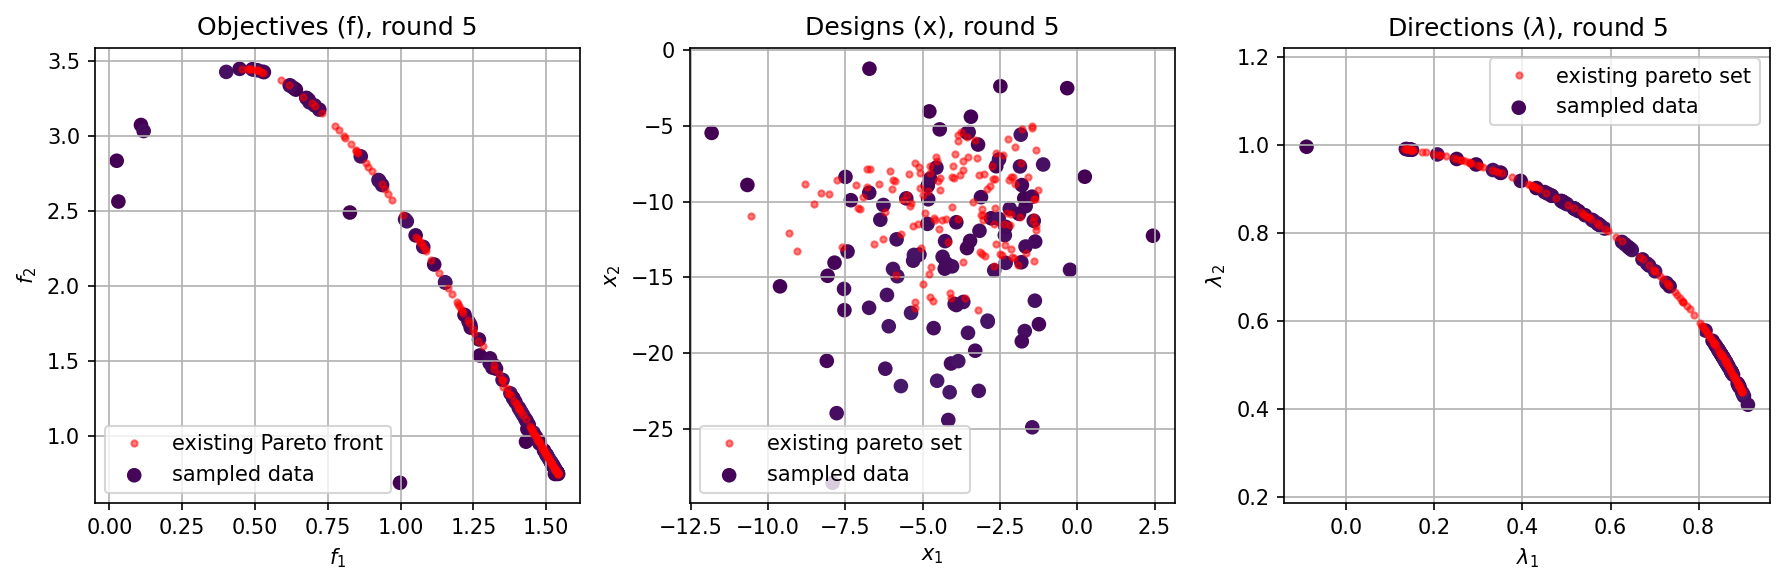


ROUND: 6
Learning preferences ...
  0: loss = -1.894
  100: loss = -1.910
  200: loss = -1.938
  300: loss = -1.987
  400: loss = -2.003
  500: loss = -2.008
  600: loss = -2.010
  700: loss = -2.011
  800: loss = -2.012
  900: loss = -2.013
  1000: loss = -2.014
  1100: loss = -2.015
  1200: loss = -2.016
  1300: loss = -2.017
Learning Pareto CPE ...
  0: loss = 0.194
  100: loss = 0.461
  200: loss = 0.323
  300: loss = 0.352
  400: loss = 0.267
  500: loss = 0.265
  600: loss = 0.321
  700: loss = 0.371
  800: loss = 0.334
  900: loss = 0.293
  1000: loss = 0.416
Learning preference CPE ...
  0: loss = 0.100
  100: loss = 0.140
  200: loss = 0.177
  300: loss = 0.205
  400: loss = 0.036
  500: loss = 0.221
  600: loss = 0.024
  700: loss = 0.107
  800: loss = 0.033
  900: loss = 0.043
  1000: loss = 0.028
Learning Pareto set model ...
  0: loss = -7.363, mean grad = 0.165
  100: loss = -6.980, mean grad = 0.001
  200: loss = -6.987, mean grad = 0.001
  300: loss = -6.976, mean grad

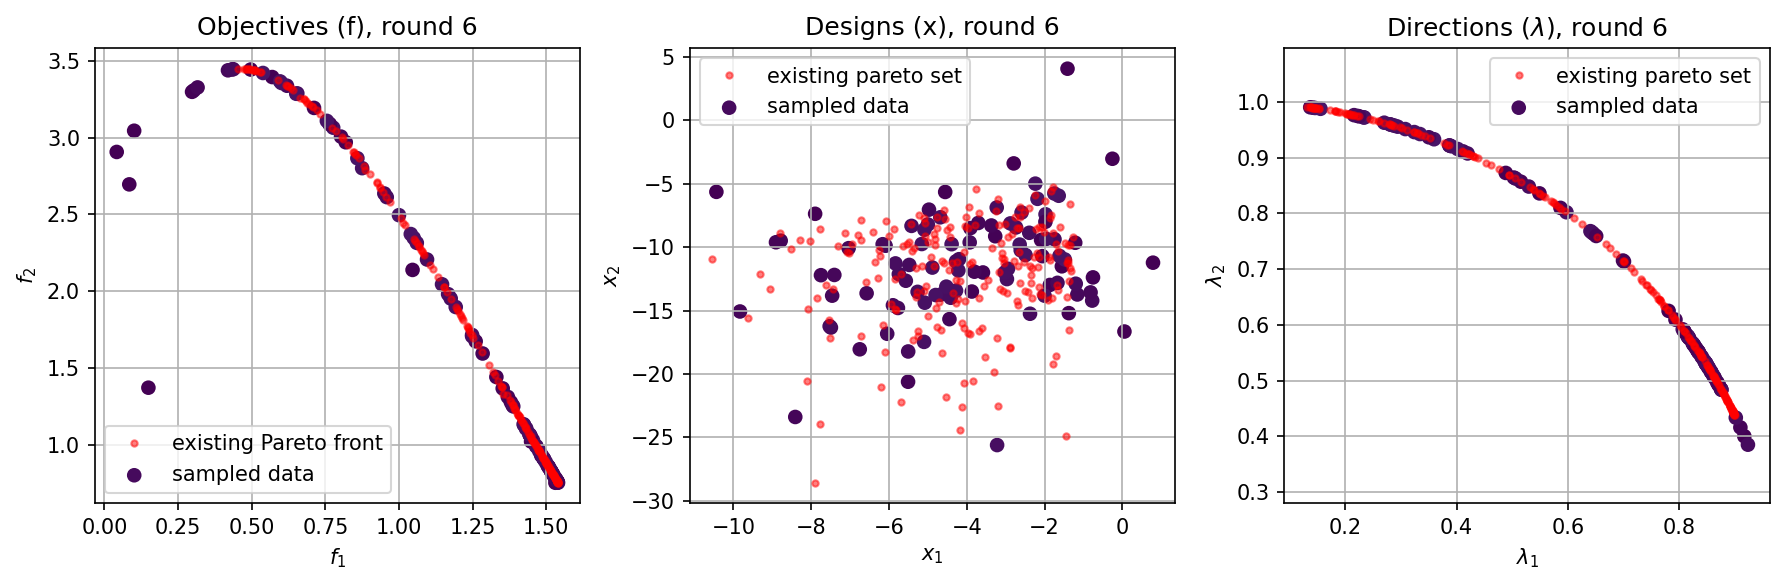


ROUND: 7
Learning preferences ...
  0: loss = -1.895
  100: loss = -1.903
  200: loss = -1.904
  300: loss = -1.905
  400: loss = -1.905
  500: loss = -1.906
  600: loss = -1.906
  700: loss = -1.907
  800: loss = -1.907
  900: loss = -1.908
  1000: loss = -1.908
Learning Pareto CPE ...
  0: loss = 0.336
  100: loss = 0.393
  200: loss = 0.373
  300: loss = 0.408
  400: loss = 0.304
  500: loss = 0.342
  600: loss = 0.390
  700: loss = 0.286
  800: loss = 0.367
  900: loss = 0.348
  1000: loss = 0.357
Learning preference CPE ...
  0: loss = 0.156
  100: loss = 0.187
  200: loss = 0.132
  300: loss = 0.027
  400: loss = 0.032
  500: loss = 0.030
  600: loss = 0.120
  700: loss = 0.259
  800: loss = 0.101
  900: loss = 0.026
  1000: loss = 0.100
Learning Pareto set model ...
  0: loss = -6.854, mean grad = -0.056
  100: loss = -6.699, mean grad = 0.001
  200: loss = -6.690, mean grad = 0.000
  300: loss = -6.687, mean grad = 0.001
  400: loss = -6.683, mean grad = 0.001
  500: loss = -6

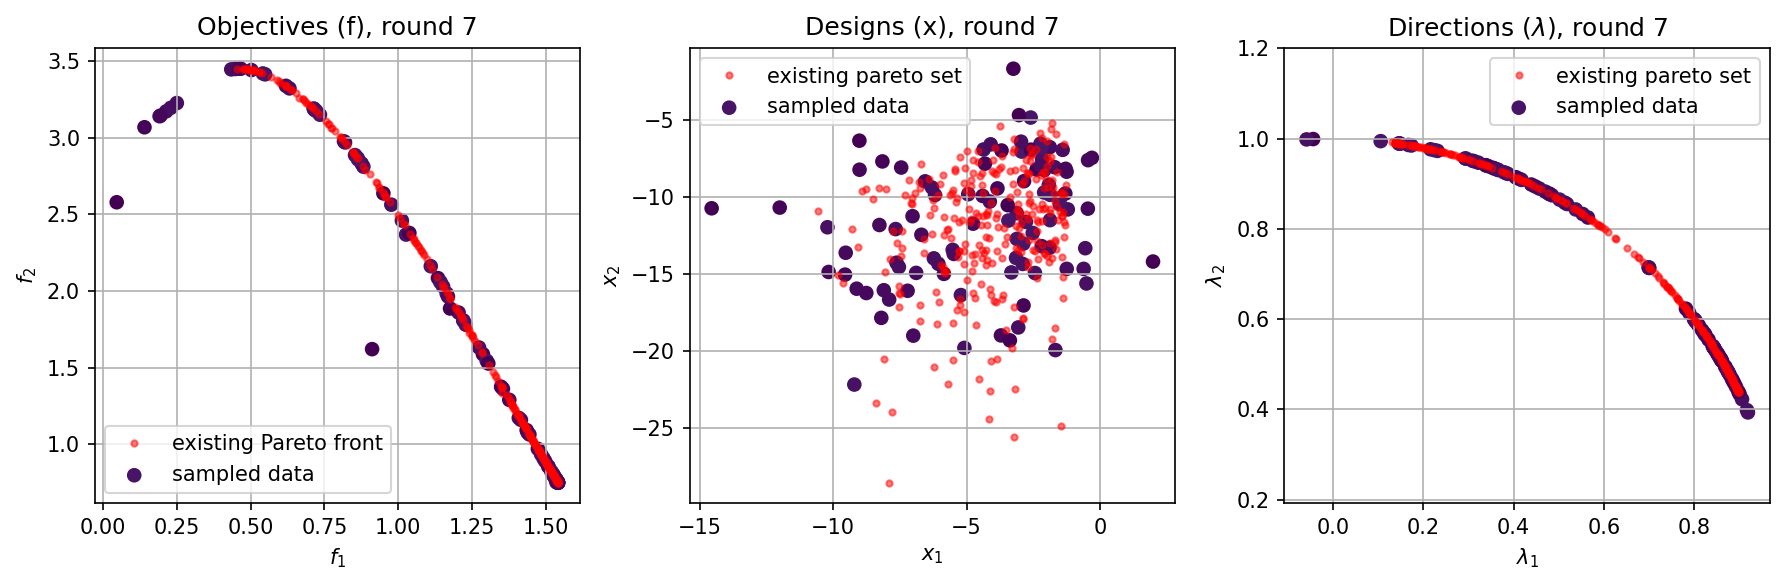


ROUND: 8
Learning preferences ...
  0: loss = -1.850
  100: loss = -1.870
  200: loss = -1.871
  300: loss = -1.872
  400: loss = -1.873
  500: loss = -1.875
  600: loss = -1.876
  700: loss = -1.877
  800: loss = -1.879
  900: loss = -1.880
  1000: loss = -1.881
Learning Pareto CPE ...
  0: loss = 0.372
  100: loss = 0.428
  200: loss = 0.412
  300: loss = 0.394
  400: loss = 0.555
  500: loss = 0.439
  600: loss = 0.444
  700: loss = 0.356
  800: loss = 0.351
  900: loss = 0.383
  1000: loss = 0.372
Learning preference CPE ...
  0: loss = 0.111
  100: loss = 0.099
  200: loss = 0.165
  300: loss = 0.025
  400: loss = 0.034
  500: loss = 0.296
  600: loss = 0.222
  700: loss = 0.035
  800: loss = 0.137
  900: loss = 0.213
  1000: loss = 0.112
Learning Pareto set model ...
  0: loss = -6.846, mean grad = -0.021
  100: loss = -6.681, mean grad = 0.000
  200: loss = -6.670, mean grad = -0.000
  300: loss = -6.663, mean grad = 0.000
  400: loss = -6.658, mean grad = 0.000
  500: loss = -

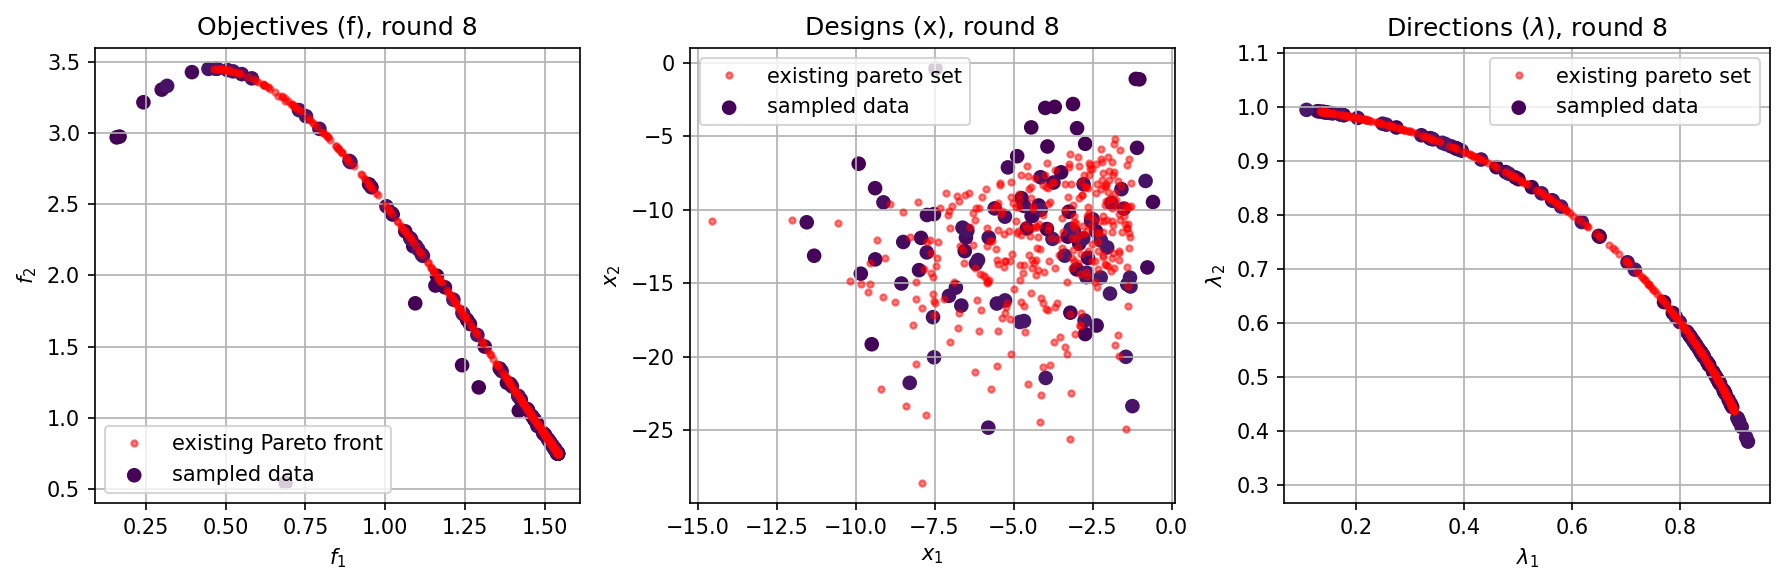


ROUND: 9
Learning preferences ...
  0: loss = -1.873
  100: loss = -1.877
  200: loss = -1.878
  300: loss = -1.879
  400: loss = -1.880
  500: loss = -1.881
  600: loss = -1.882
  700: loss = -1.883
  800: loss = -1.884
  900: loss = -1.884
  1000: loss = -1.885
Learning Pareto CPE ...
  0: loss = 0.699
  100: loss = 0.378
  200: loss = 0.395
  300: loss = 0.375
  400: loss = 0.481
  500: loss = 0.425
  600: loss = 0.439
  700: loss = 0.516
  800: loss = 0.552
  900: loss = 0.432
  1000: loss = 0.614
Learning preference CPE ...
  0: loss = 0.109
  100: loss = 0.043
  200: loss = 0.035
  300: loss = 0.278
  400: loss = 0.122
  500: loss = 0.287
  600: loss = 0.288
  700: loss = 0.303
  800: loss = 0.104
  900: loss = 0.034
  1000: loss = 0.359
Learning Pareto set model ...
  0: loss = -7.438, mean grad = 0.043
  100: loss = -7.037, mean grad = -0.001
  200: loss = -7.024, mean grad = 0.003
  300: loss = -7.019, mean grad = 0.005
  400: loss = -7.015, mean grad = -0.000
  500: loss = -

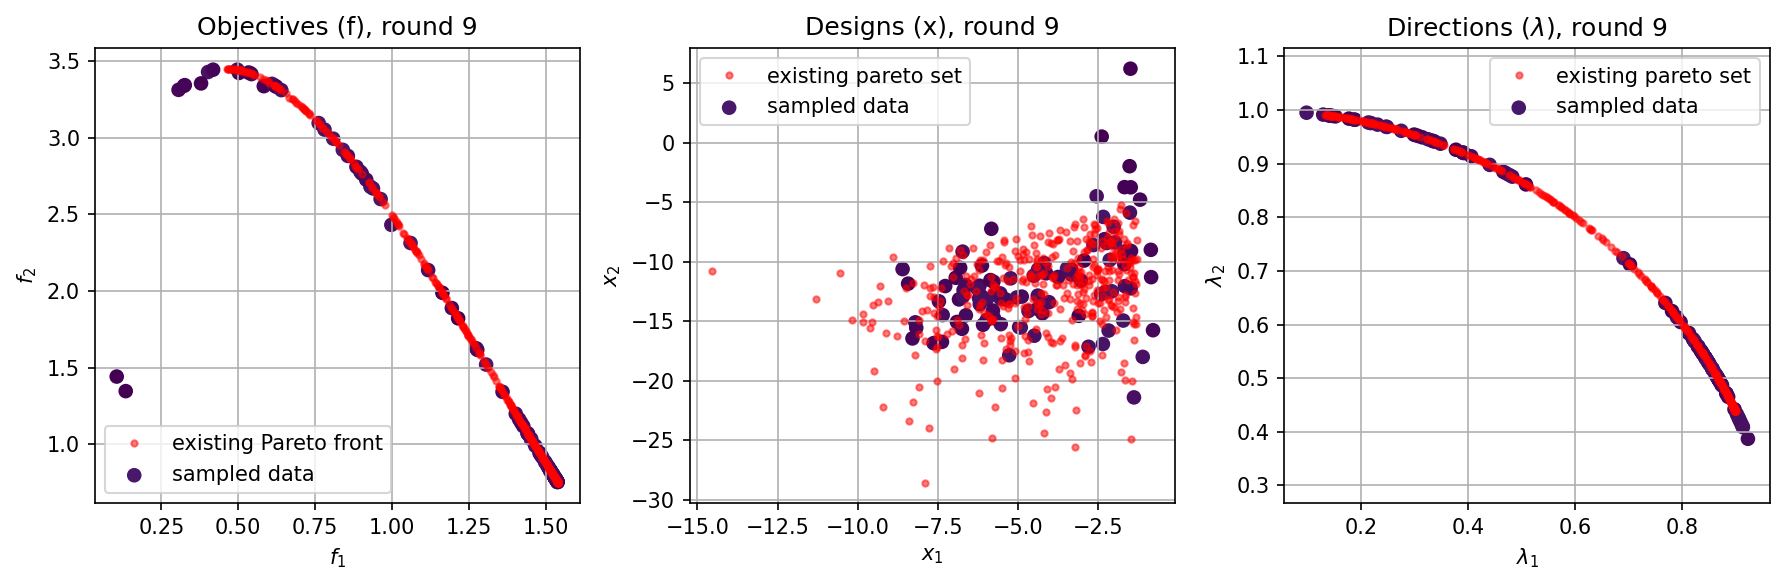


ROUND: 10
Learning preferences ...
  0: loss = -1.922
  100: loss = -1.928
  200: loss = -1.928
  300: loss = -1.928
  400: loss = -1.929
  500: loss = -1.929
  600: loss = -1.929
  700: loss = -1.930
  800: loss = -1.961
  900: loss = -1.975
  1000: loss = -1.983
  1100: loss = -1.988
  1200: loss = -1.993
  1300: loss = -1.997
  1400: loss = -2.001
  1500: loss = -2.006
  1600: loss = -2.019
  1700: loss = -2.030
  1800: loss = -2.038
  1900: loss = -2.045
  2000: loss = -2.051
  2100: loss = -2.056
  2200: loss = -2.068
  2300: loss = -2.125
  2400: loss = -2.173
  2500: loss = -2.203
  2600: loss = -2.224
  2700: loss = -2.235
  2800: loss = -2.239
  2900: loss = -2.241
  3000: loss = -2.242
  3100: loss = -2.243
  3200: loss = -2.243
  3300: loss = -2.243
  3400: loss = -2.244
  3500: loss = -2.244
Learning Pareto CPE ...
  0: loss = 0.412
  100: loss = 0.414
  200: loss = 0.354
  300: loss = 0.457
  400: loss = 0.372
  500: loss = 0.414
  600: loss = 0.724
  700: loss = 0.389
  

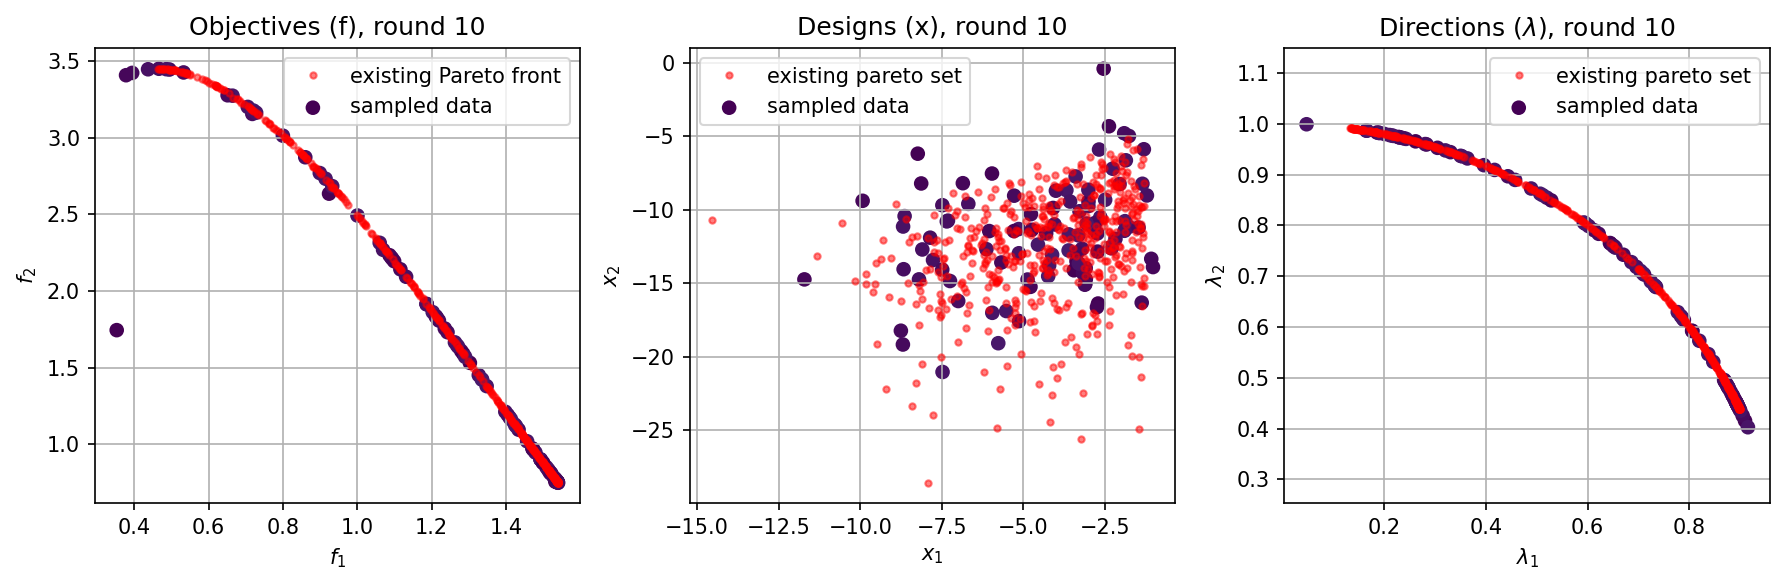

In [ ]:
for t in range(ROUNDS):
    print(f"ROUND: {t+1}")

    # Get labels and preference directions
    z = is_non_dominated_strict(y)
    U = fnn.normalize(y, p=2, dim=1)

    # Learn preference distribution
    print("Learning preferences ...")
    if USE_EMPIRICAL_PREFERENCES:
        preferences.set_preferences(U[z==1, :])
    else:
        fit_preferences(preferences, U, z, round=t)

    # Learn Pareto cpe
    print("Learning Pareto CPE ...")
    fit_pareto_cpe(pareto_cpe, X, U, z)

    # Learn Pareto cpe
    print("Learning preference CPE ...")
    fit_preference_cpe(preference_cpe, X, U)

    # Learn Pareto set generative model
    print("Learning Pareto set model ...")
    fit_vsd(acq, proposal)

    # Evaluate black box
    print("Evaluating black-box")
    Xc, Uc = proposal.sample((BATCHSIZE,))
    yc = bb(Xc)
    p = torch.exp(pareto_cpe(Xc, Uc) + preference_cpe(Xc, Uc)).detach()

    # Plot sampled data
    f, axs = plt.subplots(1, 3, dpi=150, figsize=(12, 4))
    axs[0].plot(y[z==1, 0], y[z==1, 1], 'r.', alpha=0.5, label="existing Pareto front")
    axs[0].scatter(yc[:, 0], yc[:, 1], c=p, vmin=0, vmax=1, label="sampled data")
    axs[0].set_xlabel("$f_1$")
    axs[0].set_ylabel("$f_2$")
    axs[0].grid()
    axs[0].legend()
    axs[0].set_title(f"Objectives (f), round {t+1}")
    axs[1].plot(X[z==1, 0], X[z==1, 1], 'r.', alpha=0.5, label="existing pareto set")
    axs[1].scatter(Xc[:, 0], Xc[:, 1], c=p, vmin=0, vmax=1, label="sampled data")
    axs[1].set_xlabel("$x_1$")
    axs[1].set_ylabel("$x_2$")
    axs[1].grid()
    axs[1].legend()
    axs[1].set_title(f"Designs (x), round {t+1}")
    axs[2].plot(U[z==1, 0], U[z==1, 1], 'r.', alpha=0.5, label="existing pareto set")
    axs[2].scatter(Uc[:, 0], Uc[:, 1], c=p, vmin=0, vmax=1, label="sampled data")
    axs[2].set_xlabel("$\\lambda_1$")
    axs[2].set_ylabel("$\\lambda_2$")
    axs[2].grid()
    axs[2].legend()
    axs[2].axis("equal")
    axs[2].set_title(f"Directions ($\\lambda$), round {t+1}")
    plt.tight_layout()
    plt.show()

    # Augmenting data
    X = torch.vstack((X, Xc))
    y = torch.vstack((y, yc))
    print("")


## Test preference conditioned generation

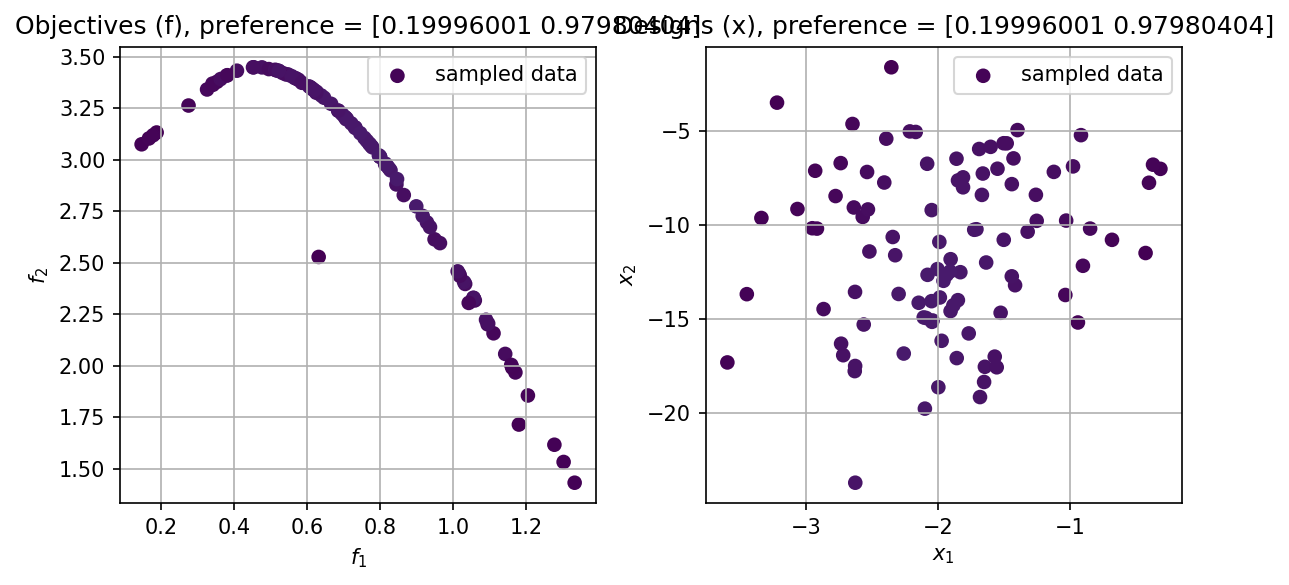

In [9]:
preference_direction = [0.2, 0.98]

Ucond = fnn.normalize(torch.tensor(preference_direction), p=2, dim=-1).tile(100, 1)
Xpref = cproposal.sample(Ucond)
ypref = bb(Xpref).detach()
ppref = torch.exp(pareto_cpe(Xpref, Ucond) + preference_cpe(Xpref, Ucond)).detach()

f, axs = plt.subplots(1, 2, dpi=150, figsize=(8, 4))
axs[0].scatter(ypref[:, 0], ypref[:, 1], c=ppref, vmin=0, vmax=1, label="sampled data")
axs[0].set_xlabel("$f_1$")
axs[0].set_ylabel("$f_2$")
axs[0].grid()
axs[0].legend()
axs[0].set_title(f"Objectives (f), preference = {Ucond[0, :].numpy()}")
axs[1].scatter(Xpref[:, 0], Xpref[:, 1], c=ppref, vmin=0, vmax=1, label="sampled data")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
axs[1].grid()
axs[1].legend()
axs[1].set_title(f"Designs (x), preference = {Ucond[0, :].numpy()}")
plt.tight_layout()
plt.show()